##### Load modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import lightgbm as lgb
from sklearn.model_selection import KFold

##### Load data

In [3]:
df = pd.read_pickle('train.pickle')

##### Train models with 5-Fold cross validation

In [4]:
cv = KFold(4)
scores = {'estimator': {0: [], 1: [], 2: [], 3: []}, 'train_score': [], 'test_score': []}
params = {
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 31,
    'bagging_fraction': 0.1,
    'bagging_freq': 1,
    'feature_fraction': 0.8,
    'learning_rate': 0.2,
    'lambda_l1': 1,
    'lambda_l2': 1,
    'seed': 0
}

for meter in range(4):
    print('========== Fit models for the {} meter dataset. =========='.format(meter))
    
    where = df.meter == meter
    X = df[where].drop(columns='meter_reading')
    y = df[where].meter_reading
    
    for idx, (train, valid) in enumerate(cv.split(X, y)):
        print('>> Fitting a model on the {} fold...'.format(idx))
        
        X_train, y_train = X.iloc[train], y.iloc[train]
        X_valid, y_valid = X.iloc[valid], y.iloc[valid]

        train = lgb.Dataset(X_train, y_train)
        valid = lgb.Dataset(X_valid, y_valid)

        estimator = lgb.train(
            params=params,
            train_set=train,
            valid_sets=(train, valid),
            num_boost_round=1000,
            early_stopping_rounds=50,
            verbose_eval=200
        )
        
        scores['estimator'][meter].append(estimator)
        scores['train_score'].append(estimator.best_score['training']['rmse'])
        scores['test_score'].append(estimator.best_score['valid_1']['rmse'])
    
    print()

========== Fit models for the 0 meter dataset. ==========
>> Fitting a model on the 0 fold...
Training until validation scores don't improve for 50 rounds.
[200]	training's rmse: 0.528586	valid_1's rmse: 0.757702
[400]	training's rmse: 0.460913	valid_1's rmse: 0.745568
Early stopping, best iteration is:
[382]	training's rmse: 0.466143	valid_1's rmse: 0.743903
>> Fitting a model on the 1 fold...
Training until validation scores don't improve for 50 rounds.
[200]	training's rmse: 0.540585	valid_1's rmse: 0.710525
[400]	training's rmse: 0.470789	valid_1's rmse: 0.690303
Early stopping, best iteration is:
[532]	training's rmse: 0.445287	valid_1's rmse: 0.684869
>> Fitting a model on the 2 fold...
Training until validation scores don't improve for 50 rounds.
[200]	training's rmse: 0.550649	valid_1's rmse: 0.751845
Early stopping, best iteration is:
[293]	training's rmse: 0.509232	valid_1's rmse: 0.739293
>> Fitting a model on the 3 fold...
Training until validation scores don't improve for 

train_score	0.717722141167395
test_score	1.0559099348745773


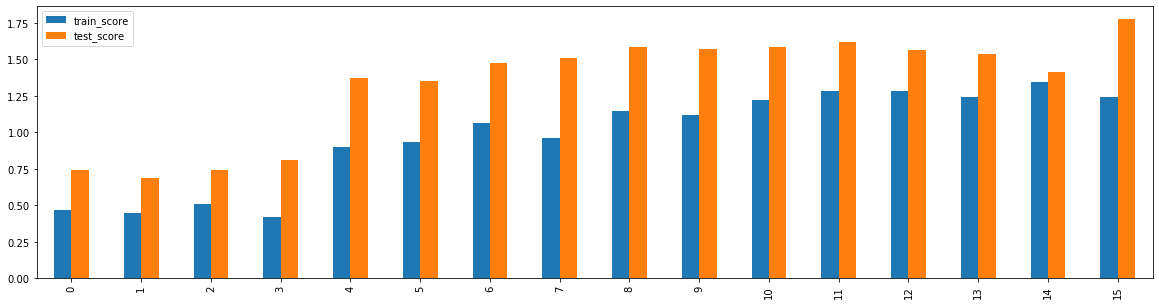

In [5]:
df_scores = pd.DataFrame()
df_scores['train_score'] = scores['train_score']
df_scores['test_score'] = scores['test_score']
df_scores.plot(kind='bar', figsize=[20, 5])

df_scores['weight'] = [11714798, 11714798, 11714798, 11714798, 4182440, 4182440, 4182440, 4182440, 2708713, 2708713, 2708713, 2708713, 1264037, 1264037, 1264037, 1264037]
print('train_score', end='\t')
print(np.average(df_scores.train_score, weights=df_scores.weight))
print('test_score', end='\t')
print(np.average(df_scores.test_score, weights=df_scores.weight))

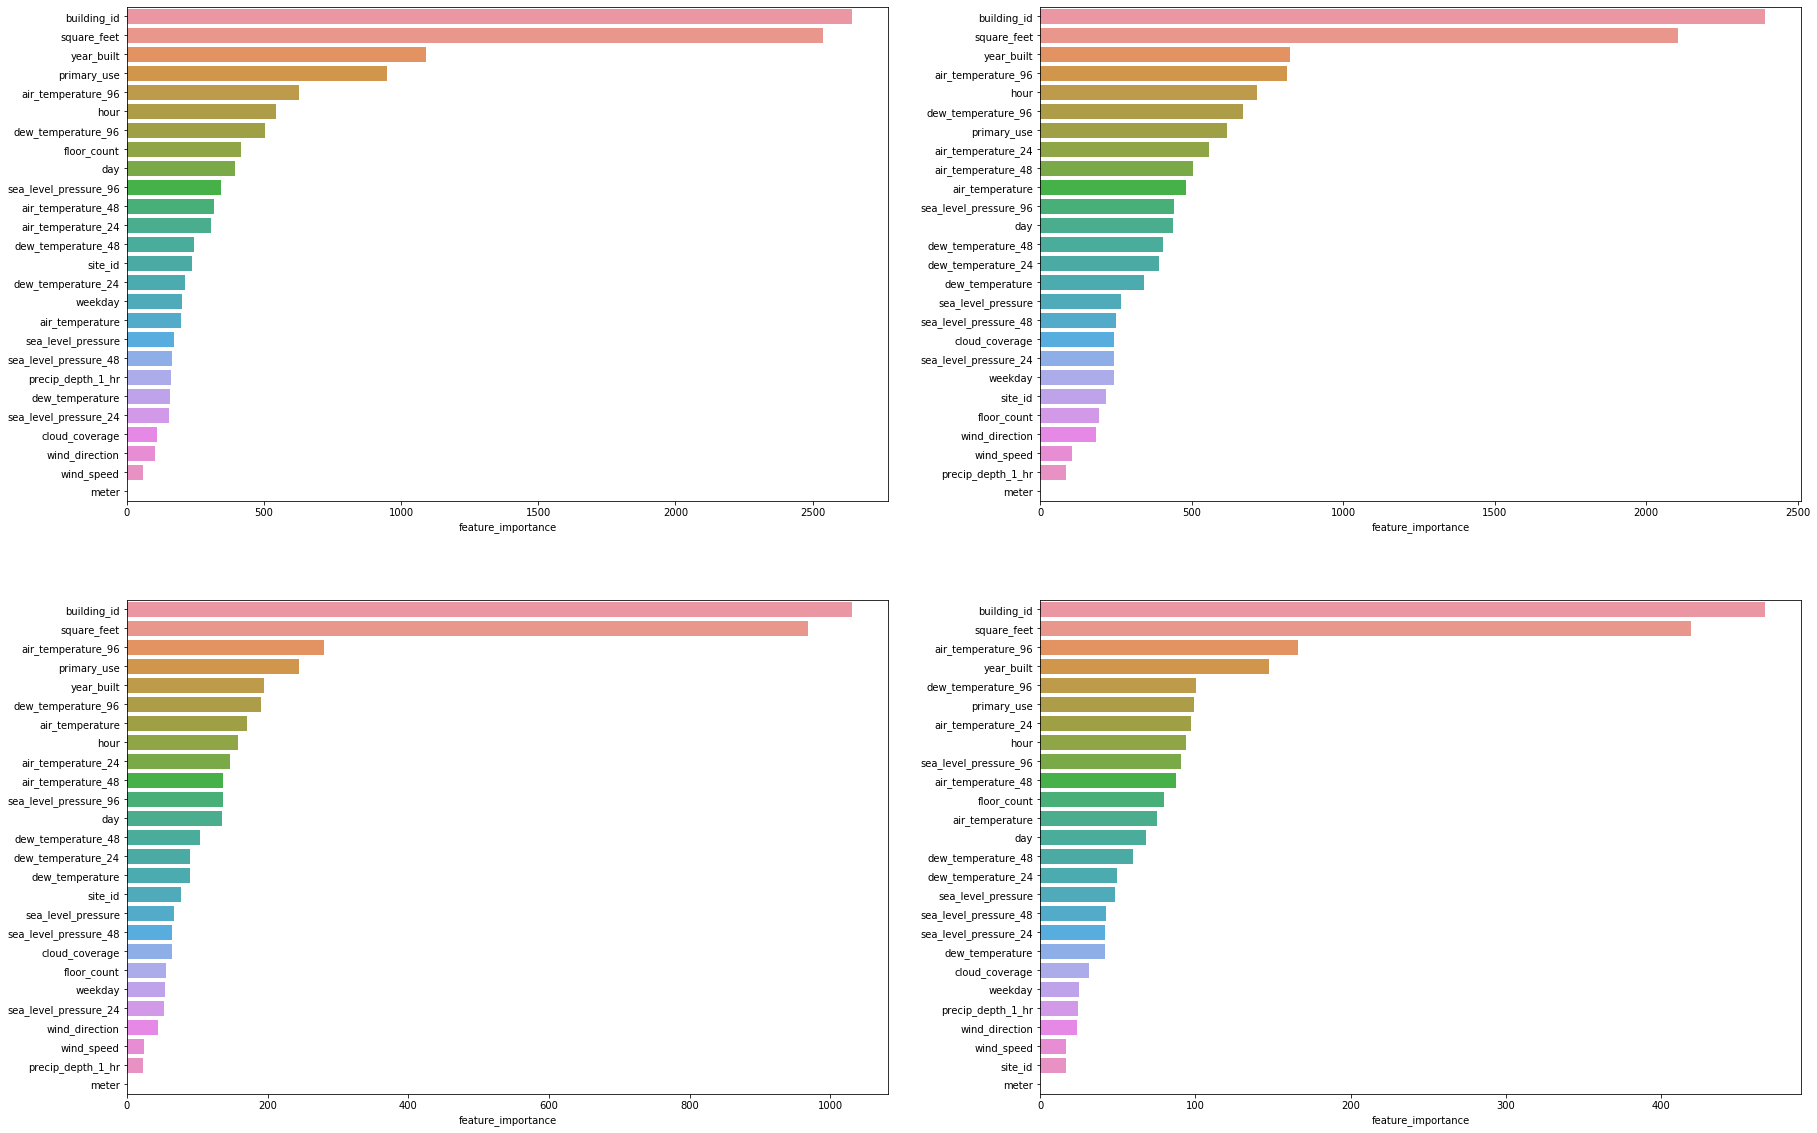

In [6]:
plt.figure(figsize=[30, 20])

for meter in range(4):
    
    feature_importances = [model.feature_importance() for model in scores['estimator'][meter]]
    feature_importances = np.mean(feature_importances, axis=0)
    feature_importances = pd.DataFrame(data=feature_importances, index=X.columns, columns=['feature_importance'])
    feature_importances.sort_values('feature_importance', ascending=False, inplace=True)

    plt.subplot(2, 2, meter + 1)
    sns.barplot(x=feature_importances.feature_importance, y=feature_importances.index, orient='h')
    
plt.show()

In [7]:
for meter in range(4):
    for idx, model in enumerate(scores['estimator'][meter]):
        model.save_model('models/{}_{}.model'.format(meter, idx))